# import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import csv
import mango
from scipy.stats import uniform
from mango.tuner import Tuner
from prophet import Prophet
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data treatment

In [178]:
df = pd.read_excel(r'C:\Users\fderouich\Desktop/csvs/Copie de TDD_FDDSAU.xlsx')
df = df[['Date','3G DL']]
df

,Date,3G DL
0,2021-01-01,24.750574
1,2021-01-02,25.267931
2,2021-01-03,25.183546
3,2021-01-04,23.348841
4,2021-01-05,23.271522
...,...,...
1164,2024-03-10,12.099744
1165,2024-03-11,11.379266
1166,2024-03-12,11.826244
1167,2024-03-13,11.857018


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


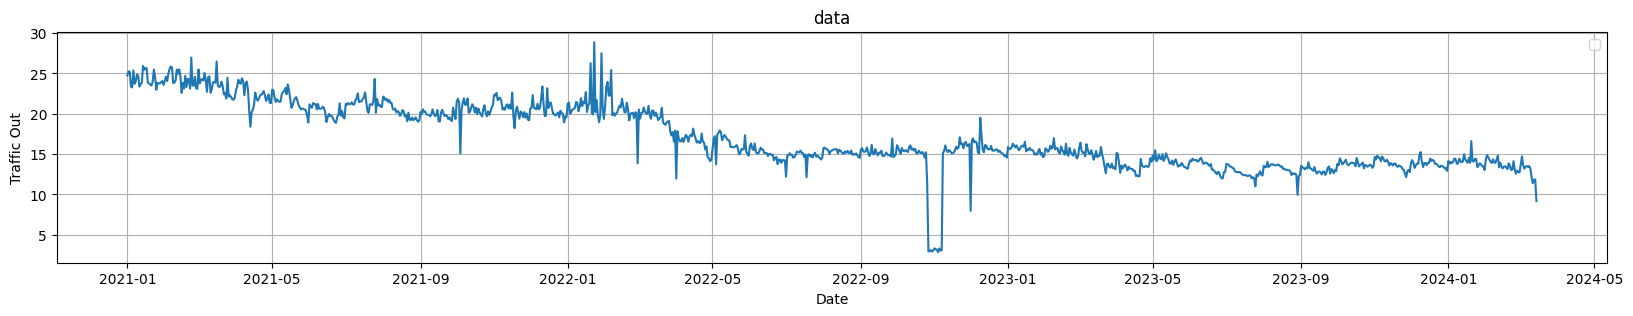

In [179]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(df['Date'], df['3G DL'])
plt.xlabel('Date')
plt.ylabel('Traffic Out')
plt.title('data')
plt.legend()
plt.grid(True)
plt.show()

In [180]:
# Data traitment
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
df['y'] = df['y'].astype(float)
df = df [df['y']>10]
#df = df [df['y']<2.7*10**6]
#df = df.drop_duplicates(subset=['ds'])
#df.replace(0.0, pd.NA, inplace=True)
#df.dropna(inplace=True)
#df.reset_index(drop=True,inplace=True)
#df = df.set_index('ds').resample('D').mean().fillna(df['y'].mean())   # fill with th mean 
df = df.set_index('ds').resample('D').mean().fillna(method='ffill')
# Step 3: Reset index and keep only 'ds' and 'y' columns
df.reset_index(inplace=True)
df = df[['ds', 'y']]
df

,ds,y
0,2021-01-01,24.750574
1,2021-01-02,25.267931
2,2021-01-03,25.183546
3,2021-01-04,23.348841
4,2021-01-05,23.271522
...,...,...
1163,2024-03-09,13.171893
1164,2024-03-10,12.099744
1165,2024-03-11,11.379266
1166,2024-03-12,11.826244


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


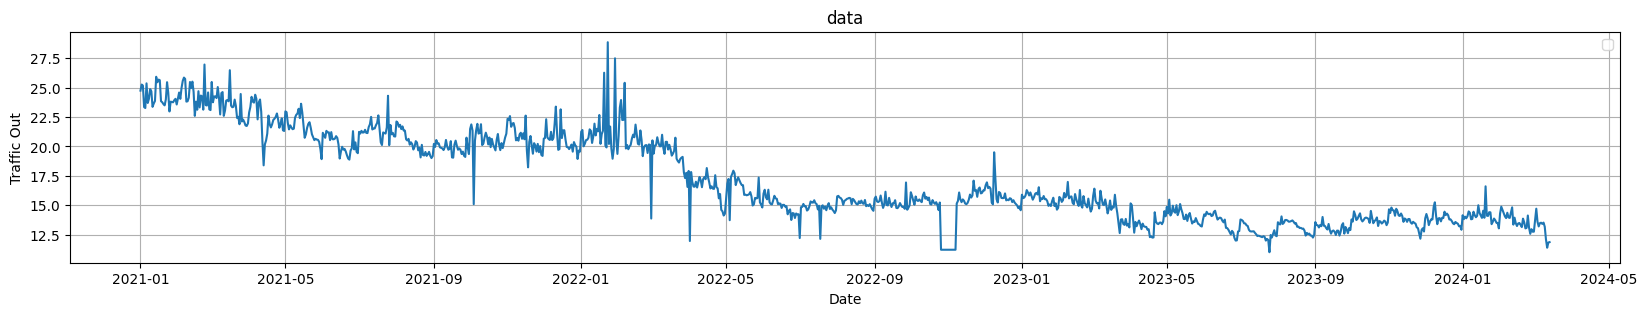

In [181]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(df['ds'], df['y'])
plt.xlabel('Date')
plt.ylabel('Traffic Out')
plt.title('data')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
# Split the data into train and test sets
train_percentage = 0.8
train_size = int(len(df) * train_percentage)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
#train_data.columns=['ds', 'y']
#test_data.columns=['ds', 'y']
test_data

,ds,y
934,2023-07-24,12.039350
935,2023-07-25,10.998894
936,2023-07-26,12.464880
937,2023-07-27,12.250719
938,2023-07-28,12.548786
...,...,...
1163,2024-03-09,13.171893
1164,2024-03-10,12.099744
1165,2024-03-11,11.379266
1166,2024-03-12,11.826244


# Parameters Fine Tuning

In [184]:

from scipy.stats import uniform
from mango.tuner import Tuner


def compute_error(lags,m):
    test_preds = [] #list to store predictions

    for d in test_data['ds'].values:
        # getting necessary df rows
        date_index = df.index[df['ds'] == d][0]
        future = df.iloc[date_index-lags:date_index]
        
        # adding new row
        entry = pd.DataFrame({
            'ds': [d],
            'y' : [np.nan]
        })
        future = pd.concat([future, entry], ignore_index = True, axis = 0)
        
        print(future)
        
        
        # making prediction
        forecast = m.predict(df=future)
        test_preds.append(forecast.loc[lags]['yhat1'])

    actual_values = test_data['y'].values
    mse = mean_squared_error(actual_values, test_preds)
    rmse = np.sqrt(mse)

    return rmse

def fine_tune():
        param_space = dict(
                   
                   n_lags = range(1,100, 5),
                   n_changepoints  = range(0, 55, 2),
                   changepoints_range  = uniform(0, 1),
                   #changepoint_prior_scale= [0.001, 0.01, 0.1, 0.5],
                   #seasonality_prior_scale = [0.01, 0.1, 1.0, 10.0],
                   #yearly_seasonality = [True, False],
                   #weekly_seasonality = [True, False],
                   #daily_seasonality = [True, False],
                   #learning_rate=uniform(0, 1),
                   
                   )
        def objective_function(args_list):
            
            params_evaluated = []
            results = []
            
            #with open(r"C:\Users\fderouich\Desktop\logs.txt", 'a') as txt_file:
            i = 0
            for params in args_list:
                        i+=1
                        print(i)
                        model = NeuralProphet(**params,n_forecasts=1,drop_missing=True)
                        model.fit(train_data, freq='D', epochs=100)
                        rmse = compute_error(params['n_lags'],model)
                        params_evaluated.append(params)
                        results.append(rmse)
                        #txt_file.write(f"number of iterations: {i} , loss :{rmse} , params: {params} \n")

            return params_evaluated, results
        
        min_rmse = 1000000
        best_p = {}
        for i in range(1):
            #np.random.seed(123)
            conf_Dict = dict()
            conf_Dict['initial_random'] = 10
            conf_Dict['num_iteration'] = 10
            tuner = Tuner(param_space, objective_function, conf_Dict)
            results = tuner.minimize()
            print('best parameters:', results['best_params'])
            print('best loss:', results['best_objective'])
            if results['best_objective'] < min_rmse:
                min_rmse = results['best_objective']
                best_p = results['best_params'].copy()
        return best_p,min_rmse

In [ ]:
import logging

# Configure logging to save to a text file
logging.basicConfig(filename=r'C:\Users\fderouich\Desktop/fine_tune_logs.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Call fine_tune() and obtain best_params
best_params = fine_tune()

# Log the best parameters
logging.info(f'Best parameters found: {best_params}')

In [ ]:
best_params,min_rmse = fine_tune()

In [186]:
print(best_params)
print(min_rmse)

{'changepoints_range': 0.06813854243125006, 'n_changepoints': 28, 'n_lags': 31}
0.46975766647414413


# Seasonality Fine Tuning 

In [187]:

def fine_tune_seasonality(train_data,test_data,best_p):
        param_space = dict(
                   name = ['monthly','quarterly'],
                   fourier = range(1,100,10)
                   )
        
        def compute_error(lags,m):
            test_preds = [] #list to store predictions

            for d in test_data['ds'].values:
                # getting necessary df rows
                date_index = df.index[df['ds'] == d][0]
                future = df.iloc[date_index-lags:date_index]
                
                # adding new row
                entry = pd.DataFrame({
                    'ds': [d],
                    'y' : [np.nan]
                })
                future = pd.concat([future, entry], ignore_index = True, axis = 0)
                print(future)
                
                
                # making prediction
                forecast = m.predict(df=future)
                test_preds.append(forecast.loc[lags]['yhat1'])

            actual_values = test_data['y'].values
            mse = mean_squared_error(actual_values, test_preds)
            rmse = np.sqrt(mse)

            return rmse
        

        def objective_function(args_list):
            
            params_evaluated = []
            results = []
            
            
            #with open(r"C:\Users\fderouich\Desktop\logs.txt", 'a') as txt_file:
            
            for params in args_list:
                        
                        model = NeuralProphet(**best_params,n_forecasts=1)
                        if params['name'] == 'monthly':
                              period = 30.5
                        else:
                              period = 91.25
                        model.add_seasonality(name=params['name'],period=period,fourier_order=params['fourier'])
                        model.fit(train_data, freq='D', epochs=100)
                        rmse = compute_error(best_p['n_lags'],model)
                        params_evaluated.append(params)
                        results.append(rmse)
                        #txt_file.write(f"number of iterations: {i} , loss :{rmse} , params: {params} \n")

            return params_evaluated, results
        
        min_rmse_s = 10000000000
        best_s = {}
        for i in range(1):
            #np.random.seed(123)
            conf_Dict = dict()
            conf_Dict['initial_random'] = 10
            conf_Dict['num_iteration'] = 30
            tuner = Tuner(param_space, objective_function, conf_Dict)
            results = tuner.minimize()
            print('best parameters:', results['best_params'])
            print('best loss:', results['best_objective'])
            if results['best_objective'] < min_rmse_s:
                min_rmse_s = results['best_objective']
                best_s = results['best_params'].copy()
        return best_s,min_rmse_s

In [ ]:
best_s,min_rmse_s = fine_tune_seasonality(train_data,test_data,best_params)
print(best_s)
print(min_rmse_s)

In [189]:
print(best_s)
print(min_rmse_s)

{'fourier': 21, 'name': 'quarterly'}
0.4594178813296639


In [ ]:
m = NeuralProphet(**best_params,n_forecasts=1)

if best_s['name'] == 'monthly':
    period = 30.5
else:
    period = 91.25
    
m.add_seasonality(name=best_s['name'],period=period,fourier_order=best_s['fourier'])

#m.add_seasonality(name='quarterly', period=91.25, fourier_order=80)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=50)

metrics = m.fit(train_data,freq='D',validation_df=test_data)

In [191]:
# Horizon
start_date = df['ds'].values[-1]
end_date = pd.to_datetime(start_date) + pd.DateOffset(months=12) - pd.DateOffset(days=1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
y = [np.nan for i in range(len(date_range))]
future = pd.DataFrame({'ds': date_range,'y':y})
Future = future.drop([0])
Future.reset_index(drop=True, inplace=True)
print(Future)

            ds   y
0   2024-03-14 NaN
1   2024-03-15 NaN
2   2024-03-16 NaN
3   2024-03-17 NaN
4   2024-03-18 NaN
..         ...  ..
359 2025-03-08 NaN
360 2025-03-09 NaN
361 2025-03-10 NaN
362 2025-03-11 NaN
363 2025-03-12 NaN

[364 rows x 2 columns]


In [ ]:
test_preds = [] #list to store predictions
lags = best_params['n_lags']
print('lllllllllll',lags)

for d in test_data['ds'].values:
    # getting necessary df rows
    date_index = df.index[df['ds'] == d][0]
    future = df.iloc[date_index-lags:date_index].copy()
    
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    print(future)
    
    
    # making prediction
    forecast = m.predict(df=future)
    test_preds.append(forecast.loc[lags]['yhat1'])

test_preds

In [193]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
actual_values = test_data['y'].values

mae = mean_absolute_error(actual_values, test_preds)
mse = mean_squared_error(actual_values, test_preds)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.3404225812478748
Mean Squared Error (MSE): 0.21094424830906652
Root Mean Squared Error (RMSE): 0.45928667334146167


In [ ]:
preds = [] #list to store predictions
lags = best_params['n_lags']
frame = df.iloc[-lags:]
for d in Future['ds'].values:
    # getting necessary df rows
    #date_index = speed.index[speed['ds'] == d][0]
    future = frame.iloc[-lags:]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    
    # making prediction
    forecast = m.predict(df=future)
    preds.append(forecast.loc[lags]['yhat1'])
    res = pd.DataFrame({'ds':[d],'y':forecast.loc[lags]['yhat1']})
    frame = pd.concat([frame,res],ignore_index = True, axis = 0)

forecast = frame.iloc[lags:]
forecast 

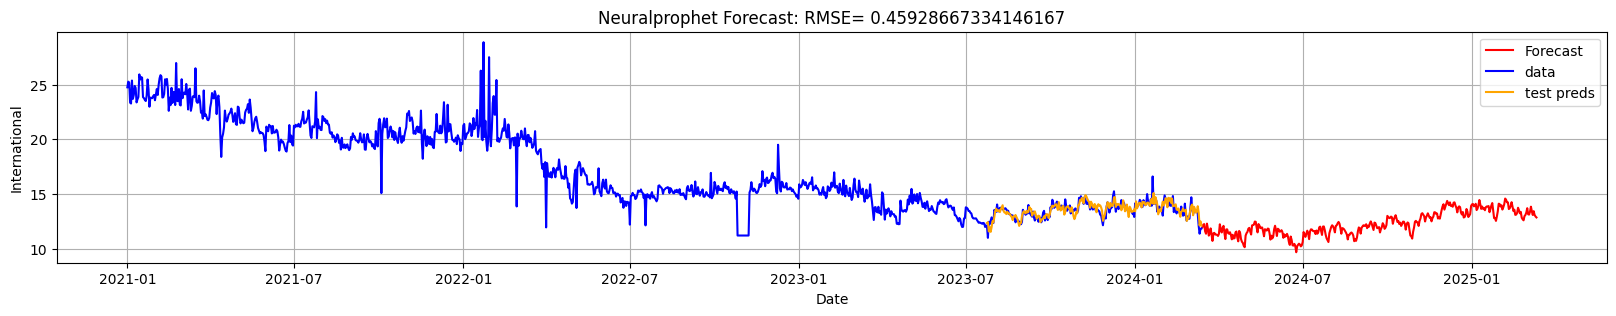

In [195]:
forecast.reset_index(drop= True,inplace = True)
date_range = forecast['ds']
forecasted_values = forecast['y']
plt.figure(figsize=(20, 3))
plt.plot(date_range, forecasted_values, label='Forecast', color='red')
plt.plot(df['ds'], df['y'], label='data', color='blue')
plt.plot(test_data['ds'], test_preds, label='test preds', color='orange')
plt.xlabel('Date')
plt.ylabel('International')
plt.title(f'Neuralprophet Forecast: RMSE= {rmse}')
plt.legend()
plt.grid(True)

plt.show()